# Wide & Deep Learning for Recommender System

- Google에서 App Store를 활용해서 발표한 논문



- Widel Models
  - memorization에 강하고, user의 특이 취향이 반영된 niche combination을 학습하기에 좋음
  - 0이 되는 pair는 학습이 불가능한 단점이 존재
  - 두 feature를 cross-product한 결과 x를 input으로 사용
    (여기서의 cross-product는 선형대수의 cross-product와는 다른 개념)

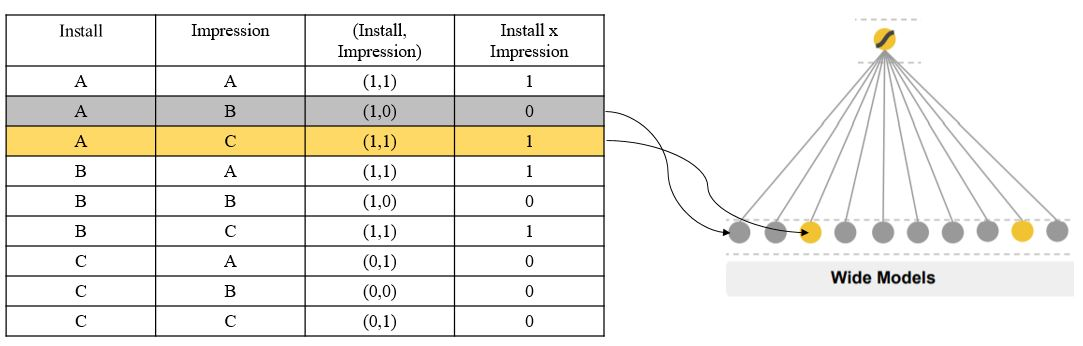

- Deep Models
  - generalization에 특화됨
  - continous feature와 임베딩된 categorical feature를 concat한 결과 a를 input으로 사용
  - 임베딩 공간 내에서 표현하므로 pair가 없는 관계도 표현 가능
   (하지만 충분한 정보가 부족하므로 제대로 된 임베딩 벡터를 얻지 못할 가능성이 큼)

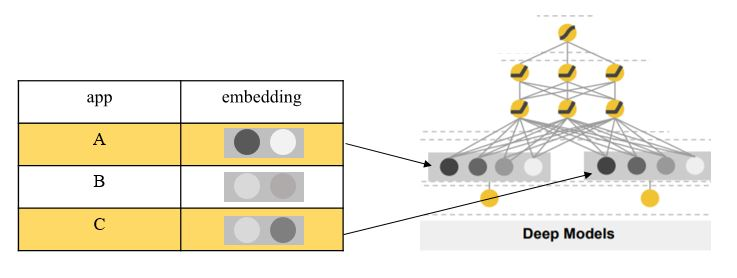

In [ ]:
!pip install pytorch-widedeep

     |████████████████████████████████| 120 kB 5.1 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/data/kmrd/kmr_dataset/datafile/kmrd-small'

In [ ]:
df = pd.read_csv(os.path.join(path,'rates.csv'))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)

In [ ]:
train_df.shape

(112568, 4)

In [ ]:
train_df = train_df[:1000]

In [ ]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

print(movies_df.shape)
print(movies_df.head())

(999, 7)
                      title  ...   country
movie                        ...          
10001                시네마 천국  ...  이탈리아,프랑스
10002              빽 투 더 퓨쳐  ...        미국
10003            빽 투 더 퓨쳐 2  ...        미국
10004            빽 투 더 퓨쳐 3  ...        미국
10005  스타워즈 에피소드 4 - 새로운 희망  ...        미국

[5 rows x 7 columns]


In [ ]:
movies_df.columns

Index(['title', 'title_eng', 'year', 'grade', 'genres', 'people', 'country'], dtype='object')

In [ ]:
dummy_genres_df = movies_df['genres'].str.get_dummies(sep='/')
train_genres_df = train_df['movie'].apply(lambda x: dummy_genres_df.loc[x])
train_genres_df.head()

,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
137023,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
92868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
94390,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22289,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
80155,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
dummy_grade_df = pd.get_dummies(movies_df['grade'], prefix='grade')
train_grade_df = train_df['movie'].apply(lambda x: dummy_grade_df.loc[x])
train_grade_df.head()

,grade_12세 관람가,grade_15세 관람가,grade_G,grade_NR,grade_PG,grade_PG-13,grade_R,grade_전체 관람가,grade_청소년 관람불가
137023,1,0,0,0,0,0,0,0,0
92868,0,0,0,0,1,0,0,0,0
94390,1,0,0,0,0,0,0,0,0
22289,0,0,0,0,0,0,0,1,0
80155,1,0,0,0,0,0,0,0,0


In [ ]:
train_df['year'] = train_df.apply(lambda x: movies_df.loc[x['movie']]['year'], axis=1)

In [ ]:
train_df = pd.concat([train_df, train_grade_df, train_genres_df], axis=1)
train_df.head()

,user,movie,rate,time,year,grade_12세 관람가,grade_15세 관람가,grade_G,grade_NR,grade_PG,grade_PG-13,grade_R,grade_전체 관람가,grade_청소년 관람불가,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
137023,48423,10764,10,1212241560,1987.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
92868,17307,10170,10,1122185220,1985.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
94390,18180,10048,10,1573403460,2016.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22289,1498,10001,9,1432684500,2013.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
80155,12541,10022,10,1370458140,1980.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
wide_cols = list(dummy_genres_df.columns) + list(dummy_grade_df.columns)
wide_cols

['SF',
 '가족',
 '공포',
 '느와르',
 '다큐멘터리',
 '드라마',
 '로맨스',
 '멜로',
 '모험',
 '뮤지컬',
 '미스터리',
 '범죄',
 '서부',
 '서사',
 '스릴러',
 '애니메이션',
 '액션',
 '에로',
 '전쟁',
 '코미디',
 '판타지',
 'grade_12세 관람가',
 'grade_15세 관람가',
 'grade_G',
 'grade_NR',
 'grade_PG',
 'grade_PG-13',
 'grade_R',
 'grade_전체 관람가',
 'grade_청소년 관람불가']

In [ ]:
print(len(wide_cols))
print(wide_cols)

wide_cols = wide_cols[:3]

30
['SF', '가족', '공포', '느와르', '다큐멘터리', '드라마', '로맨스', '멜로', '모험', '뮤지컬', '미스터리', '범죄', '서부', '서사', '스릴러', '애니메이션', '액션', '에로', '전쟁', '코미디', '판타지', 'grade_12세 관람가', 'grade_15세 관람가', 'grade_G', 'grade_NR', 'grade_PG', 'grade_PG-13', 'grade_R', 'grade_전체 관람가', 'grade_청소년 관람불가']


In [ ]:
# wide_cols = ['genre', 'grade']
# cross_cols = [('genre', 'grade')]
wide_cols

['SF', '가족', '공포']

In [ ]:
import itertools
from itertools import product  
unique_combinations = list(list(zip(wide_cols, element)) 
                           for element in product(wide_cols, repeat = len(wide_cols))) 
cross_cols = [item for sublist in unique_combinations for item in sublist]
cross_cols = [x for x in cross_cols if x[0] != x[1]]
cross_cols = list(set(cross_cols))
print(cross_cols)

[('공포', 'SF'), ('가족', 'SF'), ('SF', '가족'), ('공포', '가족'), ('SF', '공포'), ('가족', '공포')]


In [ ]:
# embed_cols = [('genre', 16),('grade', 16)]
embed_cols = list(set([(x[0], 16) for x in cross_cols]))
continuous_cols = ['year']

print(embed_cols)
print(continuous_cols)

[('공포', 16), ('가족', 16), ('SF', 16)]
['year']


In [ ]:
target = train_df['rate'].apply(lambda x: 1 if x > 9 else 0).values

# Wide & Deep

In [ ]:
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy
from pytorch_widedeep import Trainer

## Wide Component

In [ ]:
preprocess_wide = WidePreprocessor(wide_cols=wide_cols, crossed_cols=cross_cols)
X_wide = preprocess_wide.fit_transform(train_df)
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)

In [ ]:
X_wide

array([[ 1,  3,  5, ..., 19, 22, 26],
       [ 1,  3,  5, ..., 19, 22, 26],
       [ 1,  3,  5, ..., 19, 22, 26],
       ...,
       [ 1,  3,  5, ..., 19, 22, 26],
       [ 1,  3,  5, ..., 19, 22, 26],
       [ 1,  3,  5, ..., 19, 22, 26]])

In [ ]:
print(X_wide[5])
print(X_wide[6])
print(X_wide[-5])
print(X_wide[-3])
print(X_wide[25])

[ 1  3  6  8 11 15 20 23 27]
[ 1  3  5  7 11 15 19 22 26]
[ 1  3  5  7 11 15 19 22 26]
[ 1  3  5  7 11 15 19 22 26]
[ 2  3  5 10 12 16 19 25 26]


In [ ]:
print(np.unique(X_wide))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]


In [ ]:
wide

Wide(
  (wide_linear): Embedding(29, 1, padding_idx=0)
)

## Deep Component

In [ ]:
preprocess_tab = TabPreprocessor(embed_cols=embed_cols, continuous_cols=continuous_cols)
X_tab = preprocess_tab.fit_transform(train_df)
deeptabular = TabMlp(
    mlp_hidden_dims=[64, 32],
    column_idx=preprocess_tab.column_idx,
    embed_input=preprocess_tab.embeddings_input,
    continuous_cols=continuous_cols
)

In [ ]:
deeptabular

TabMlp(
  (embed_layers): ModuleDict(
    (emb_layer_공포): Embedding(3, 16, padding_idx=0)
    (emb_layer_가족): Embedding(3, 16, padding_idx=0)
    (emb_layer_SF): Embedding(3, 16, padding_idx=0)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (tab_mlp): MLP(
    (mlp): Sequential(
      (dense_layer_0): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=49, out_features=64, bias=True)
        (2): ReLU(inplace=True)
      )
      (dense_layer_1): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=64, out_features=32, bias=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)

#Build and Train

In [ ]:
# wide and deep
model = WideDeep(wide=wide, deeptabular=deeptabular)

# train the model
trainer = Trainer(model, objective="binary", metrics=[Accuracy])
trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=5,
    batch_size=256,
    val_split=0.1,
)

valid: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s, loss=nan, metrics={'acc': 0.0}]


In [ ]:
X_tab.shape

(1000, 4)

In [ ]:
X_wide.shape

(1000, 9)